Module imports

In [1]:
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pyomo.environ as pyo
from pyomo.core import Model
from pyomo.core.expr.relational_expr import EqualityExpression
from polars import DataFrame, Series, col

Data

In [2]:
# Base power
base_power = 1000

# Network data
nodes = DataFrame(
    [
        {"id": "N1", "load": 0},
        {"id": "N2", "load": 0},
        {"id": "N3", "load": 150},
    ]
)
generators = DataFrame(
    [  # excludes "capacity", "cost"
        {"id": "G1", "node_id": "N1"},
        {"id": "G2", "node_id": "N2"},
        {"id": "G3", "node_id": "N1"},
    ]
)
lines = DataFrame(
    # fmt: off
    [
        {"from_node_id": "N1", "to_node_id": "N2", "susceptance": 0.25, "capacity": 30.},
        {"from_node_id": "N1", "to_node_id": "N3", "susceptance": 0.25, "capacity": 300.},
        {"from_node_id": "N2", "to_node_id": "N3", "susceptance": 0.25, "capacity": 300.},
    ]
    # fmt: on
)
offers = DataFrame(
    [
        {"id": "G1a", "generator_id": "G1", "max_quantity": 200.0, "price": 10.00},
        {"id": "G2a", "generator_id": "G2", "max_quantity": 200.0, "price": 12.00},
        {"id": "G3a", "generator_id": "G3", "max_quantity": 200.0, "price": 14.00},
        # {"id": "G1b", "generator_id": "G1", "max_quantity": 100.0, "price": 20.00},
        # {"id": "G2b", "generator_id": "G2", "max_quantity": 100.0, "price": 22.00},
        # {"id": "G3b", "generator_id": "G3", "max_quantity": 100.0, "price": 24.00},
    ]
).sort(by=["generator_id", "price"])


Examine the data in tabular format

In [3]:
lines

from_node_id,to_node_id,susceptance,capacity
str,str,f64,f64
"""N1""","""N2""",0.25,30.0
"""N1""","""N3""",0.25,300.0
"""N2""","""N3""",0.25,300.0


Index sets

In [4]:
Nodes = range(nodes.height)
Lines = range(lines.height)
Offers = range(offers.height)
Generators = range(generators.height)


In [5]:
list(Nodes)

[0, 1, 2]

Define decision variables

In [6]:
model = pyo.ConcreteModel()


def supply_bounds(model: Model, o: int) -> tuple[float, float]:
    return (0.0, offers[o, "max_quantity"])


def flow_bounds(model: Model, ell: int) -> tuple[float, float]:
    capacity = lines[ell, "capacity"]
    return (-capacity, +capacity)


model.p = pyo.Var(Offers, bounds=supply_bounds)
model.f = pyo.Var(Lines, bounds=flow_bounds)
model.theta = pyo.Var(Nodes, bounds=(-math.pi, +math.pi))
model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)  # nodal prices

In [7]:
model.f.pprint()

f : Size=3, Index={0, 1, 2}
    Key : Lower  : Value : Upper : Fixed : Stale : Domain
      0 :  -30.0 :  None :  30.0 : False :  True :  Reals
      1 : -300.0 :  None : 300.0 : False :  True :  Reals
      2 : -300.0 :  None : 300.0 : False :  True :  Reals


Objective function to be minimized

In [8]:
model.total_cost = pyo.Objective(
    expr=sum(offers[o, "price"] * model.p[o] for o in Offers),
    sense=pyo.minimize,
)

Incidence relationships

In [9]:
def network_incidence(n: int, ell: int) -> int:
    if nodes[n, "id"] == lines[ell, "from_node_id"]:
        return -1
    if nodes[n, "id"] == lines[ell, "to_node_id"]:
        return +1
    else:
        return 0


def supply_incidence(n: int, g: int, o: int) -> bool:
    node_generator: bool = nodes[n, "id"] == generators[g, "node_id"]
    generator_offer: bool = generators[g, "id"] == offers[o, "generator_id"]
    return node_generator and generator_offer

Constraints on decision variables

In [10]:
def balance_rule(model: Model, n: int) -> EqualityExpression:
    return (
        sum(model.p[o] for g in Generators for o in Offers if supply_incidence(n, g, o))
        + sum(network_incidence(n, ell) * model.f[ell] for ell in Lines)
        == nodes[n, "load"]
    )


def flow_rule(model: Model, ell: int) -> EqualityExpression:
    return (
        sum(
            base_power
            * sign
            * lines[ell, "susceptance"]
            * model.theta[n]
            for n in Nodes
            if (sign := network_incidence(n, ell))
        )
        == model.f[ell]
    )


model.balance = pyo.Constraint(Nodes, rule=balance_rule)
model.flow = pyo.Constraint(Lines, rule=flow_rule)
model.reference_angle = pyo.Constraint(expr=model.theta[0] == 0.0)

In [11]:
model.balance.pprint()

balance : Size=3, Index={0, 1, 2}, Active=True
    Key : Lower : Body                               : Upper : Active
      0 :   0.0 : p[0] + p[2] - f[0] - f[1] + 0*f[2] :   0.0 :   True
      1 :   0.0 :        f[0] + 0*f[1] - f[2] + p[1] :   0.0 :   True
      2 : 150.0 :               0*f[0] + f[1] + f[2] : 150.0 :   True


In [12]:
model.pprint()

3 Var Declarations
    f : Size=3, Index={0, 1, 2}
        Key : Lower  : Value : Upper : Fixed : Stale : Domain
          0 :  -30.0 :  None :  30.0 : False :  True :  Reals
          1 : -300.0 :  None : 300.0 : False :  True :  Reals
          2 : -300.0 :  None : 300.0 : False :  True :  Reals
    p : Size=3, Index={0, 1, 2}
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :   0.0 :  None : 200.0 : False :  True :  Reals
          1 :   0.0 :  None : 200.0 : False :  True :  Reals
          2 :   0.0 :  None : 200.0 : False :  True :  Reals
    theta : Size=3, Index={0, 1, 2}
        Key : Lower              : Value : Upper             : Fixed : Stale : Domain
          0 : -3.141592653589793 :  None : 3.141592653589793 : False :  True :  Reals
          1 : -3.141592653589793 :  None : 3.141592653589793 : False :  True :  Reals
          2 : -3.141592653589793 :  None : 3.141592653589793 : False :  True :  Reals

1 Objective Declarations
    total_cost : Si

Solve the optimization problem with [HiGHS](https://en.wikipedia.org/wiki/HiGHS_optimization_solver):

In [13]:
solver = pyo.SolverFactory("highs")
results = solver.solve(model, tee=True)  # tee output to console

Running HiGHS 1.10.0 (git hash: fd86653): Copyright (c) 2025 HiGHS under MIT licence terms
LP   has 7 rows; 9 cols; 19 nonzeros
Coefficient ranges:
  Matrix [1e+00, 2e+02]
  Cost   [1e+01, 1e+01]
  Bound  [3e+00, 3e+02]
  RHS    [2e+02, 2e+02]
Presolving model
5 rows, 7 cols, 14 nonzeros  0s
0 rows, 1 cols, 0 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve : Reductions: rows 0(-7); columns 0(-9); elements 0(-19) - Reduced to empty
Solving the original LP from the solution after postsolve
Model status        : Optimal
Objective value     :  1.5600000000e+03
Relative P-D gap    :  0.0000000000e+00
HiGHS run time      :          0.00


Extract optimal decision values:

In [14]:
supply = [pyo.value(model.p[o]) for o in Offers]
flow = [pyo.value(model.f[ell]) for ell in Lines]
angles_deg = [pyo.value(model.theta[n]) * 180 / math.pi for n in Nodes]
prices = [model.dual[model.balance[n]] for n in Nodes]

offers = offers.with_columns([Series("supply", supply)])
lines = lines.with_columns([Series("flow", flow)])
nodes = nodes.with_columns([Series("theta_deg", angles_deg), Series("price", prices)])

supply_prices = offers.group_by("generator_id").agg(col("price"))
supply_totals = offers.group_by("generator_id").agg(col("supply").sum())
generators = generators.join(
    supply_totals, left_on="id", right_on="generator_id", how="left"
)
generators = generators.join(
    supply_prices, left_on="id", right_on="generator_id", how="left"
)
generators = generators.with_columns(
    col("price")
    .map_elements(lambda x: ", ".join(map("{:.2f}".format, sorted(x))), return_dtype=str)
    .alias("prices")
)

In [15]:
nodes

id,load,theta_deg,price
str,i64,f64,f64
"""N1""",0,-0.0,10.0
"""N2""",0,6.875494,12.0
"""N3""",150,20.626481,11.0


In [16]:
generators

id,node_id,supply,price,prices
str,str,f64,list[f64],str
"""G1""","""N1""",120.0,[10.0],"""10.00"""
"""G2""","""N2""",30.0,[12.0],"""12.00"""
"""G3""","""N1""",0.0,[14.0],"""14.00"""


In [17]:
network = nx.DiGraph()

network.add_nodes_from(nodes["id"])
network.add_nodes_from(generators["id"])
bus_color = ["lightblue" for _ in nodes["id"]]
generator_color = ["lightgreen" for _ in generators["id"]]
node_color = [*bus_color, *generator_color]

network.add_edges_from(zip(lines["from_node_id"], lines["to_node_id"]))
network.add_edges_from(zip(generators["id"], generators["node_id"]))
line_utilization = lines["flow"].abs() / lines["capacity"]
connection_utilization = [0.0 for _ in generators["id"]]
edge_utilization = [*line_utilization, *connection_utilization]


In [18]:
def mapvalues(f, keys, *values) -> dict:
    return dict(zip(keys, map(f, *values)))


def offset(pos: dict, dx: float, dy: float) -> dict:
    dxy = np.array([dx, dy])
    return {node: xy + dxy for node, xy in pos.items()}

In [19]:
nodal_price_labels = mapvalues("${:.2f}/MWh".format, nodes["id"], nodes["price"])
offer_price_labels = mapvalues(
    "${:}/MWh".format, generators["id"], generators["prices"]
)
flow_labels = mapvalues(
    "{:.0f}MW/{:.0f}MW".format,
    zip(lines["from_node_id"], lines["to_node_id"]),
    lines["flow"],
    lines["capacity"],
)
supply_labels = mapvalues(
    "{:.0f}MW".format,
    zip(generators["id"], generators["node_id"]),
    generators["supply"],
)

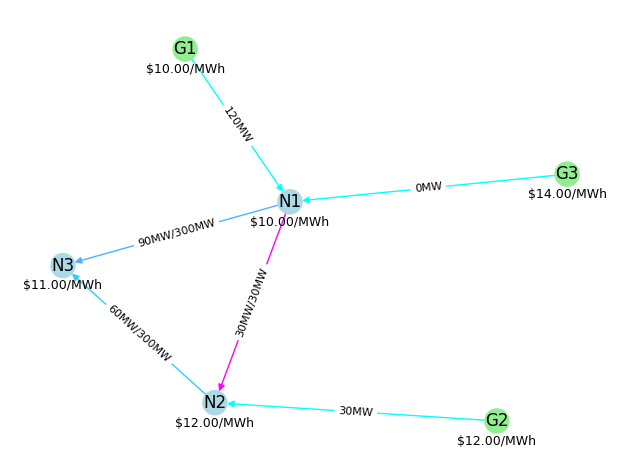

In [20]:
pos = nx.spring_layout(network, k=3 / math.sqrt(network.number_of_nodes()), seed=0)
nx.draw_networkx(
    network, 
    pos,
    with_labels=True,
    node_color=node_color,
    edge_color=edge_utilization,
    edge_cmap=cm.cool,
    edge_vmin=0.0,
    edge_vmax=1.0,
)
nx.draw_networkx_labels(
    network,
    offset(pos, 0, -0.1),
    labels=nodal_price_labels | offer_price_labels,
    font_size=9,
)
nx.draw_networkx_edge_labels(
    network, pos, edge_labels=flow_labels | supply_labels, font_size=8
)
plt.axis("off")
plt.tight_layout()
plt.show()